# Exploration of the Heart Disease Data Set

## Introduction

The dataset is taken from the Cleveland, Ohio database. This dataset is a collaboration with physicians from Hungary, Switzerland, Virginia, and Ohio. This database describes 76 attributes, but all experiments that have been published use only 14 as a reference. The `num` column describes the presence of heart disease in the patient. The `col_vessels` column indicates the number of major blood vessels coloured by fluoroscopy. The `slope` column indicates the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope). The `st_depression` column indicates the ST depression induced by exercise relative to rest. The `ex_ang` column indicates whether the patient has exercise induced angina (1 = yes, 0 = no). The `max_hr` column describes indicates a numerical value of the maximum heart rate achieved. The `rest_ecg` indicates the resting electrocardiac results (0 = normal, 1 = ST-T wave abnormality, 2 = probable/definite left ventricular hypertrophy). The `fbs` column indicates whether the patient has a fasting blood sugar of greater than 120 mg/dl (1 = true, 0 = false). The `chol` column describes the serum cholesterol level in mg/dl per patient. The `rest_bps` indicates the resting blood pressure (mm Hg). The `chest_pain` column describes the chest pain in the patient with varying types of anginas (1 = typical angina, 2 = atypical angina, 3 = nonanginal pain, 4 = asymptomatic). The `sex` column indicates the gender of the patient (1 = male, 0 = female). The `defect` column refers to the defect of the heart (3 = normal, 6 = defect, 7 = reversible defect). Lastly, the `age` column indicates the age of the patient. 

The question we will try to answer is whether a patient will be diagnosed with heart disease, and it's severity. We have a number of predictors, and we will use the technique of backward selection to narrow down our predictors to the few attributes that allow us to predict this most accurately.



## Methods & Results

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(MASS)
library(GGally)
library(caret)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Read the dataset, clean and wrangle the data into a tidy format.

Download the dataset from the url and store it into a local file.

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

download.file(url, destfile = "data/processed.cleveland.data")

Read the file into the dataframe `heart_disease_original`. We will need to manually specify the column types, which are given on the database website.

In [3]:
heart_disease_original <- read_csv("data/processed.cleveland.data",
                                   # add column names
                                   col_names = c("age",
                                                 "sex",
                                                 "chest_pain", 
                                                 "rest_bps", 
                                                 "chol", 
                                                 "fbs", 
                                                 "rest_ecg", 
                                                 "max_hr", 
                                                 "ex_ang", 
                                                 "st_depression", 
                                                 "slope", 
                                                 "col_vessels", 
                                                 "defect", 
                                                 "num"))

head(heart_disease_original, 10)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): col_vessels, defect
dbl (12): age, sex, chest_pain, rest_bps, chol, fbs, rest_ecg, max_hr, ex_an...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


Now, we need to wrangle `heart_disease_original` by removing all rows that contain a question mark, filtering essentially NA values and changing the type of `col_vessels` and `defect` to be doubles.

In [4]:
heart_disease <- heart_disease_original %>% 

                    # remove all rows that contain a question
                    # mark (esentially NA values) to supress
                    # warnings from R
                    filter(defect != "?", col_vessels != "?") %>%

                    # change columns col_vessels and defect to be numeric
                    # to allow for tidymodels to work properly
                    mutate(col_vessels = as.numeric(col_vessels),
                           defect = as.numeric(defect),
                           num = as_factor(num)) %>%

                    # remove rows with NA values
                    na.omit()     


head(heart_disease, 10)

age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


Let's check the distribution for our target variable `num`. 

In [5]:
heart_disease %>% 
   group_by(num) %>% 
   summarize(count = n()) %>%
   # we can find the percent by dividing count for each
   # num by nrow(heart_disease) which gives us the amount
   # of rows in heart_disease
   mutate(percent = 100 * (count/nrow(heart_disease)))

num,count,percent
<fct>,<int>,<dbl>
0,160,53.872054
1,54,18.181818
2,35,11.784512
3,35,11.784512
4,13,4.377104


It looks like there is an uneven proportion of data for `num`. There is a proportionally high amount of rows where `num` is 0 vs where `num` is 1, 2, 3, or 4. Due to the lack of distribution of data, we will likely not get a very accurate k-nn model. We will solve this problem by splitting our data into two. First, we will create a binary representation of this dataframe, where `0` means no heart disease and `1` means heart disease. Then, we will split off the rows where `num = 1, 2, 3, 4` so that if our model predicts possibility of heart disease for the patient, we can then find out how severe the heart disease is.

#### Binary representation

In [6]:
heart_disease_bin <- heart_disease

heart_disease_bin$num <- as.character(heart_disease$num)
heart_disease_bin$num[heart_disease$num != 0] <- 1
heart_disease_bin$num <- as.factor(heart_disease_bin$num)

heart_disease_bin %>% 
   group_by(num) %>% 
   summarize(count = n()) %>%
   # we can find the percent by dividing count for each
   # num by nrow(heart_disease) which gives us the amount
   # of rows in heart_disease
   mutate(percent = 100 * (count/nrow(heart_disease)))

num,count,percent
<fct>,<int>,<dbl>
0,160,53.87205
1,137,46.12795


In [7]:
pos_heart_disease <- heart_disease |>
    filter(num != 0)

pos_heart_disease %>% 
   group_by(num) %>% 
   summarize(count = n()) %>%
   # we can find the percent by dividing count for each
   # num by nrow(heart_disease) which gives us the amount
   # of rows in heart_disease
   mutate(percent = 100 * (count/nrow(heart_disease)))

num,count,percent
<fct>,<int>,<dbl>
1,54,18.181818
2,35,11.784512
3,35,11.784512
4,13,4.377104


Now we have created `heart_diease_bin` and `pos_heart_disease`, the former of which only has `num` values of 0 or 1 and the latter of which only has nonzero `num` values. 

### Split the dataset into training set and testing set.

We will split our dataset `heart_diease` into a testing and training set. We will upsample the training set, which will hopefully increase the accuracy of our model.

In [8]:
# setting a seed which will not be changed for the rest of the project
set.seed(2023)

heart_disease_split <- initial_split(heart_disease_bin, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

head(heart_disease_training)

age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
57,1,3,150,168,0,0,174,0,1.6,1,0,3,0
48,0,3,130,275,0,0,139,0,0.2,1,0,3,0
58,0,1,150,283,1,2,162,0,1.0,1,0,3,0


### Selecting Predictors

#### Backward Selection

Section 6.8.3 of the data science textbook briefly mentions the method of forward selection in R. However, the method it shows is far too manual. The more manual we make our program, the more prone it is to errors. Therefore, we will be using the `MASS` library to import a few functions which allow us to do the same thing [6].

 Therefore, instead of forward selection, we will use backward selection to remove one predictor at a time. Then, we will check if the AIC of the new model goes down. We will remove the predictor which lowers the AIC the most until we get to a point where removing predictors increases AIC. 
 
AIC is a measure used to evaluate the goodness of fit of a statistical model. It takes into account both the complexity of the model and its performance in explaining the data. The main goal of AIC is to find the best balance between model complexity and its ability to explain the observed data. Lower AIC values indicate better model performance, while higher AIC values indicate worse model performance [1].

During the backward selection process, we remove the predictor that, when removed, results in the lowest AIC value for the reduced model. We continue to remove predictors one by one, stopping when any further removal of predictors would result in an increase in AIC. By removing predictors that reduce the AIC of the model, we can identify the combination of predictors that provides the best balance between model complexity and predictive accuracy.

In [9]:
# the MASS library requires all values to be an integer
heart_disease_training_aic <- heart_disease_training %>%
    mutate(num = as.numeric(num))

In [10]:
null <- lm(num ~ 1, data = heart_disease_training_aic) # 1 means no predictor 
full <- lm(num ~ ., data = heart_disease_training_aic) # use all predictors
 
# this function goes from full (all predictors) to null (no predictors) 
# and removes the predictor whose removal decreases the AIC the most
stepAIC(full, scope = list(lower = null, upper=full), 
         data = heart_disease_training_aic,
         direction = 'backward')

Start:  AIC=-443.65
num ~ age + sex + chest_pain + rest_bps + chol + fbs + rest_ecg + 
    max_hr + ex_ang + st_depression + slope + col_vessels + defect

                Df Sum of Sq    RSS     AIC
- chol           1   0.03515 26.561 -445.35
- st_depression  1   0.05642 26.583 -445.18
- age            1   0.07716 26.604 -445.00
- rest_ecg       1   0.17993 26.706 -444.15
- slope          1   0.19381 26.720 -444.03
- rest_bps       1   0.22132 26.748 -443.80
- fbs            1   0.22355 26.750 -443.78
<none>                       26.526 -443.65
- max_hr         1   0.41169 26.938 -442.23
- chest_pain     1   0.61871 27.145 -440.53
- sex            1   0.86185 27.388 -438.55
- ex_ang         1   0.93857 27.465 -437.93
- defect         1   1.84309 28.369 -430.74
- col_vessels    1   3.15210 29.678 -420.72

Step:  AIC=-445.35
num ~ age + sex + chest_pain + rest_bps + fbs + rest_ecg + max_hr + 
    ex_ang + st_depression + slope + col_vessels + defect

                Df Sum of Sq    RSS  


Call:
lm(formula = num ~ sex + chest_pain + max_hr + ex_ang + slope + 
    col_vessels + defect, data = heart_disease_training_aic)

Coefficients:
(Intercept)          sex   chest_pain       max_hr       ex_ang        slope  
   0.879380     0.152846     0.067130    -0.002342     0.193006     0.096704  
col_vessels       defect  
   0.141677     0.061856  


### Creation of k-nn Model

Since we don't know the best value of $k$ to use for the model, we will use `vfold` and the `tune()` function to determine the accuracy of the model at different values of $k$. Firstly, we will create the recipe.

In [11]:
# create recipe for k-nn using the previously mentioned predictors
heart_disease_recipe <- recipe(num ~ sex + chest_pain + max_hr + ex_ang + slope + col_vessels + defect,
                               data = heart_disease_training) %>%
                        # normalize data
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

We will start the $k$ value at 1 and set the upper limit to 70. We chose the upper limit of 70 since it is close enough to 120 (the majority classifier) that our model will naturally start losing accuracy. In an ideal world, we would have the upper limit at exactly the majority classifier but doing `vfold` with 100+ neighbours takes a long computation time.

In [12]:
# we will use a step value of 5 to provide high accuracy while not severly effecting
# computation speed
k_vals <- tibble(neighbors = seq(from = 1, to = 70, by = 5))

# create a standard 5 fold model of the training data
heart_disease_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# create the specification of our k-nn model using tune() for the neighbours value
heart_disease_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                 set_engine("kknn") %>%
                 set_mode("classification")

heart_disease_tune_results <- workflow() %>%
  # add our recipe and model
  add_recipe(heart_disease_recipe) %>%
  add_model(heart_disease_tune) %>%
  # tune the grid to involve vfold and tuned neighbour 
  tune_grid(resamples = heart_disease_vfold, grid = k_vals) %>%
  collect_metrics() 

# sort accuracies by the accuracy of the neighbour count
(accuracies <- heart_disease_tune_results %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mean)))

# get the k value with the highest accuracy
(best_k_value <- accuracies %>%
    dplyr::select(neighbors) %>%
    slice(1) %>%
    pull())

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
56,accuracy,binary,0.8333333,5,0.01805158,Preprocessor1_Model12
61,accuracy,binary,0.8287879,5,0.01814671,Preprocessor1_Model13
51,accuracy,binary,0.8244444,5,0.02553009,Preprocessor1_Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,accuracy,binary,0.7975758,5,0.02062277,Preprocessor1_Model02
21,accuracy,binary,0.7975758,5,0.01644201,Preprocessor1_Model05
1,accuracy,binary,0.7385859,5,0.01588510,Preprocessor1_Model01


[1] 56

It looks like a neighbour count of around 41-46 gives us the highest accuracy. To further hone in on the exact neighbour count which gives us the maximal accuracy, we will repeat this process once more with a more precise range for our k values.

In [13]:
# since 46 seems to be in the same range as 41 for the accuracy, we will let this tibble
# extend more to the right of the best_k_value than to the left
k_vals_precise <- tibble(neighbors = seq(from = best_k_value - 5, to = best_k_value + 10, by = 1))


# the rest of this code is essentially copy pasted from the last time we ran this
# workflow, but with updated names; notice that we can reuse our old recipe and 
# specification
heart_disease_tune_results_precise <- workflow() %>%
  add_recipe(heart_disease_recipe) %>%
  add_model(heart_disease_tune) %>%
  tune_grid(resamples = heart_disease_vfold, grid = k_vals_precise) %>%
  collect_metrics() 

(accuracies_precise <- heart_disease_tune_results_precise %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mean)))

(best_k_value_precise <- accuracies_precise %>%
    dplyr::select(neighbors) %>%
    slice(1) %>%
    pull())

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
55,accuracy,binary,0.8333333,5,0.01805158,Preprocessor1_Model05
56,accuracy,binary,0.8333333,5,0.01805158,Preprocessor1_Model06
57,accuracy,binary,0.8333333,5,0.01805158,Preprocessor1_Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
52,accuracy,binary,0.8244444,5,0.02553009,Preprocessor1_Model02
65,accuracy,binary,0.8198990,5,0.01840464,Preprocessor1_Model15
66,accuracy,binary,0.8198990,5,0.01840464,Preprocessor1_Model16


[1] 55

We will now plot the accuracy vs the neighbour count to get a better idea of what this data looks like.

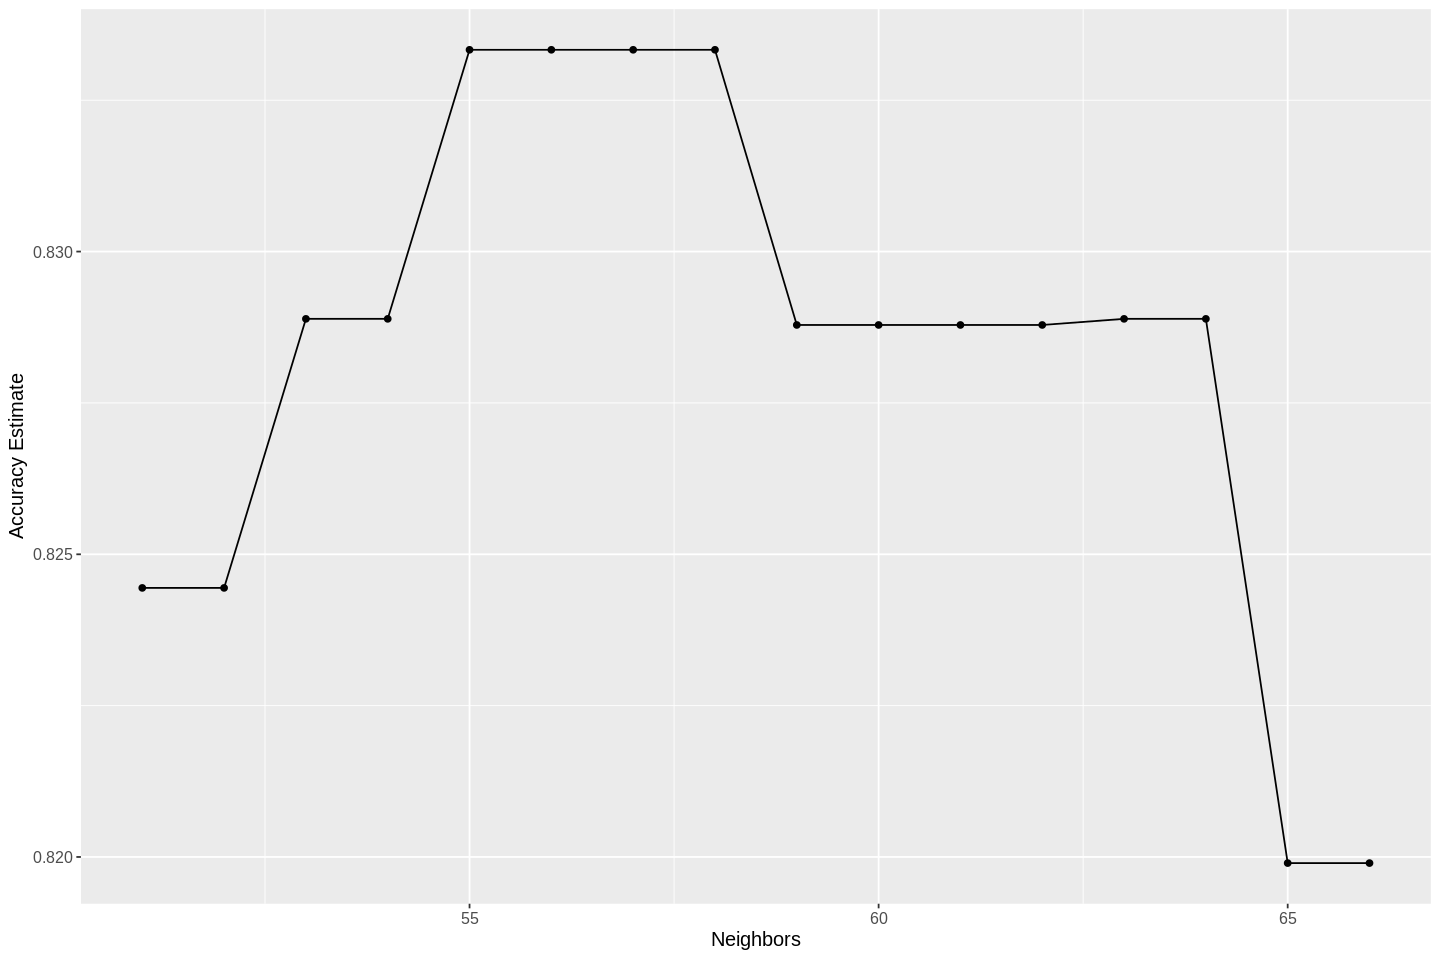

In [14]:
options(repr.plot.width = 12, repr.plot.height = 8)

(accuracy_vs_k_precise <- ggplot(accuracies_precise, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)))

It looks like $k = 38$ gives the highest accuracy value, which tapers and rises all the way to $k = 43$. From there it tapers off to a lower accuracy.

### Final Model with Known K-Value

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = best_k_value_precise) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(heart_disease_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = heart_disease_training)

In [16]:
heart_disease_test_predictions <- predict(knn_fit, heart_disease_testing) %>%
  bind_cols(heart_disease_testing)

(heart_disease_test_predictions %>%
  metrics(truth = num, estimate = .pred_class) %>%
  filter(.metric == "accuracy"))

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8666667


It looks like our final model accuracy is 59%. If we remember from before, our majority classifier was `num = 0` which made up of 54% of the original data. This means that our model's accuracy improved upon just guessing every patient to have no heart disease by 5%. This may not seem like much, but due to the un-uniformity of our data, it makes sense that we did not achieve an incredibly accurate model.

Let's visualize how our confusion matrix looks like.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



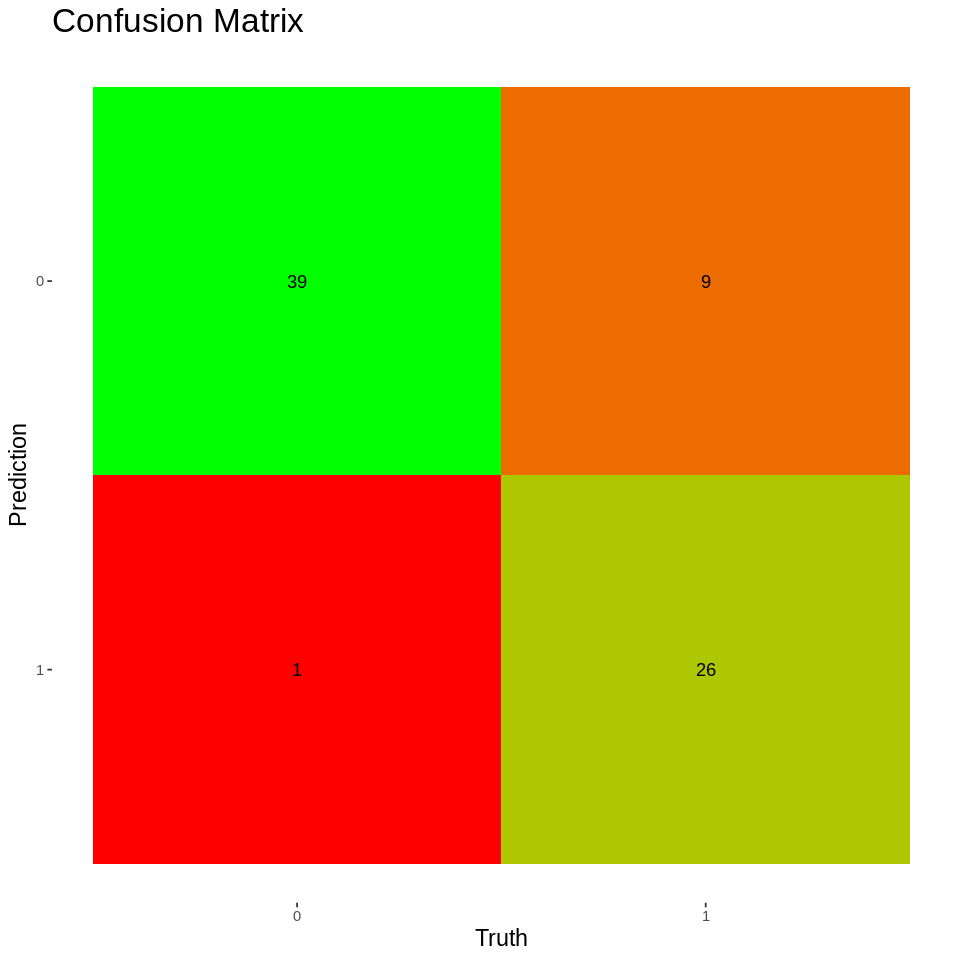

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)

confusion <- heart_disease_test_predictions %>%
             conf_mat(truth = num, estimate = .pred_class)

autoplot(confusion, type = "heatmap") +
  scale_fill_gradient(low = "red", high = "green") +
  ggtitle("Confusion Matrix") +
  # make all text bigger
  theme(
      axis.title.x = element_text(size = 14),
      axis.title.y = element_text(size = 14),
      plot.title = element_text(size = 20)
  )

It looks like our model is extremely accurate at guessing when the patient has no heart disease. There was only 1 case where the patient did not have heart disease but our model assumed they did. However, where our model struggles is classifying patients with heart disease. For a `num` value of 2 and 3, our model only correctly classified once whereas it was never accurate in correctly classifying a `num` value of 4. This makes sense, since we had an under-representation of the `num` values of 1, 2, 3, and 4 in our original data which we had to compensate for by upsampling.

We still have a bit more left though. Whenever our model detected heart disease (predicted a 1 for `num`), we need to run it through another k-nn model.

In [20]:
(heart_disease_subset <- heart_disease_test_predictions |> 
    dplyr::select(-num) |>
    rename(num = .pred_class))

num,age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3
0,37,1,3,130,250,0,0,187,0,3.5,3,0,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,59,1,4,164,176,1,2,90,0,1.0,2,2,6
0,45,1,1,110,264,0,0,132,0,1.2,2,0,7
1,68,1,4,144,193,1,0,141,0,3.4,2,2,7


In [21]:
heart_disease_split_subset <- initial_split(heart_disease_subset, prop = 0.75, strata = num)
heart_disease_training_subset <- training(heart_disease_split)
heart_disease_testing_subset <- testing(heart_disease_split_subset)

head(heart_disease_training_subset)

age,sex,chest_pain,rest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,st_depression,slope,col_vessels,defect,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
57,1,3,150,168,0,0,174,0,1.6,1,0,3,0
48,0,3,130,275,0,0,139,0,0.2,1,0,3,0
58,0,1,150,283,1,2,162,0,1.0,1,0,3,0


In [22]:
# the MASS library requires all values to be an integer
heart_disease_training_aic_subset <- heart_disease_training_subset %>%
    mutate(num = as.numeric(num))

null <- lm(num ~ 1, data = heart_disease_training_aic_subset) # 1 means no predictor 
full <- lm(num ~ ., data = heart_disease_training_aic_subset) # use all predictors
 
# this function goes from full (all predictors) to null (no predictors) 
# and removes the predictor whose removal decreases the AIC the most
stepAIC(full, scope = list(lower = null, upper=full), 
         data = heart_disease_training_aic_subset,
         direction = 'backward')

Start:  AIC=-443.65
num ~ age + sex + chest_pain + rest_bps + chol + fbs + rest_ecg + 
    max_hr + ex_ang + st_depression + slope + col_vessels + defect

                Df Sum of Sq    RSS     AIC
- chol           1   0.03515 26.561 -445.35
- st_depression  1   0.05642 26.583 -445.18
- age            1   0.07716 26.604 -445.00
- rest_ecg       1   0.17993 26.706 -444.15
- slope          1   0.19381 26.720 -444.03
- rest_bps       1   0.22132 26.748 -443.80
- fbs            1   0.22355 26.750 -443.78
<none>                       26.526 -443.65
- max_hr         1   0.41169 26.938 -442.23
- chest_pain     1   0.61871 27.145 -440.53
- sex            1   0.86185 27.388 -438.55
- ex_ang         1   0.93857 27.465 -437.93
- defect         1   1.84309 28.369 -430.74
- col_vessels    1   3.15210 29.678 -420.72

Step:  AIC=-445.35
num ~ age + sex + chest_pain + rest_bps + fbs + rest_ecg + max_hr + 
    ex_ang + st_depression + slope + col_vessels + defect

                Df Sum of Sq    RSS  


Call:
lm(formula = num ~ sex + chest_pain + max_hr + ex_ang + slope + 
    col_vessels + defect, data = heart_disease_training_aic_subset)

Coefficients:
(Intercept)          sex   chest_pain       max_hr       ex_ang        slope  
   0.879380     0.152846     0.067130    -0.002342     0.193006     0.096704  
col_vessels       defect  
   0.141677     0.061856  


In [23]:
# create recipe for k-nn using the previously mentioned predictors
heart_disease_recipe_subset <- recipe(num ~ sex + chest_pain + max_hr + ex_ang + slope + col_vessels + defect,
                               data = heart_disease_training_subset) %>%
                        # normalize data
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

In [24]:
# create a standard 5 fold model of the training data
heart_disease_vfold_subset <- vfold_cv(heart_disease_training_subset, v = 5, strata = num)

heart_disease_tune_results_ss <- workflow() %>%
  # add our recipe and model
  add_recipe(heart_disease_recipe_subset) %>%
  add_model(heart_disease_tune) %>%
  # tune the grid to involve vfold and tuned neighbour 
  tune_grid(resamples = heart_disease_vfold_subset, grid = k_vals) %>%
  collect_metrics() 

# sort accuracies by the accuracy of the neighbour count
(accuracies_ss <- heart_disease_tune_results_ss %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mean)))

# get the k value with the highest accuracy
(best_k_value_ss <- accuracies_ss %>%
    dplyr::select(neighbors) %>%
    slice(1) %>%
    pull())

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,accuracy,binary,0.8379798,5,0.02151148,Preprocessor1_Model07
41,accuracy,binary,0.8379798,5,0.02685159,Preprocessor1_Model09
46,accuracy,binary,0.8379798,5,0.02685159,Preprocessor1_Model10
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.8064646,5,0.02380626,Preprocessor1_Model03
6,accuracy,binary,0.8018182,5,0.02586164,Preprocessor1_Model02
1,accuracy,binary,0.7520202,5,0.01130456,Preprocessor1_Model01


[1] 31

In [25]:
# since 46 seems to be in the same range as 41 for the accuracy, we will let this tibble
# extend more to the right of the best_k_value than to the left
k_vals_precise_ss <- tibble(neighbors = seq(from = best_k_value_ss - 5, to = best_k_value_ss + 10, by = 1))

# the rest of this code is essentially copy pasted from the last time we ran this
# workflow, but with updated names; notice that we can reuse our old recipe and 
# specification
heart_disease_tune_results_precise_ss <- workflow() %>%
  add_recipe(heart_disease_recipe_subset) %>%
  add_model(heart_disease_tune) %>%
  tune_grid(resamples = heart_disease_vfold_subset, grid = k_vals_precise_ss) %>%
  collect_metrics() 

(accuracies_precise_ss <- heart_disease_tune_results_precise_ss %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mean)))

(best_k_value_precise_ss <- accuracies_precise_ss %>%
    dplyr::select(neighbors) %>%
    slice(1) %>%
    pull())

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,accuracy,binary,0.8425253,5,0.02327477,Preprocessor1_Model04
30,accuracy,binary,0.8425253,5,0.02327477,Preprocessor1_Model05
27,accuracy,binary,0.8379798,5,0.02151148,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
39,accuracy,binary,0.8335354,5,0.02601946,Preprocessor1_Model14
40,accuracy,binary,0.8335354,5,0.02601946,Preprocessor1_Model15
26,accuracy,binary,0.8289899,5,0.02293374,Preprocessor1_Model01


[1] 29

In [27]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = best_k_value_precise_ss) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit_ss <- workflow() %>%
  add_recipe(heart_disease_recipe_subset) %>%
  add_model(knn_spec) %>%
  fit(data = heart_disease_training_subset)

In [28]:
heart_disease_test_predictions_ss <- predict(knn_fit_ss, heart_disease_testing_subset) %>%
  bind_cols(heart_disease_testing_subset)

(heart_disease_test_predictions_ss %>%
  metrics(truth = num, estimate = .pred_class) %>%
  filter(.metric == "accuracy"))

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9473684


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



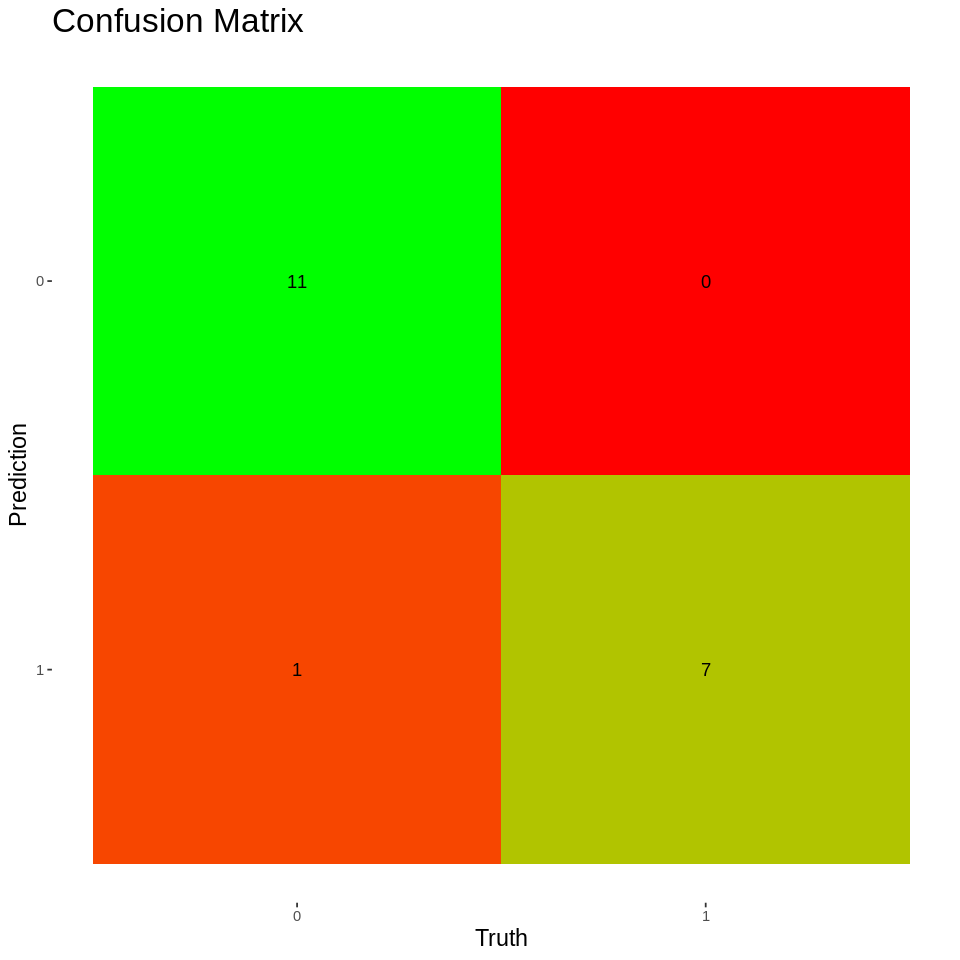

In [30]:
options(repr.plot.width = 8, repr.plot.height = 8)

confusion_ss <- heart_disease_test_predictions_ss %>%
             conf_mat(truth = num, estimate = .pred_class)

autoplot(confusion_ss, type = "heatmap") +
  scale_fill_gradient(low = "red", high = "green") +
  ggtitle("Confusion Matrix") +
  # make all text bigger
  theme(
      axis.title.x = element_text(size = 14),
      axis.title.y = element_text(size = 14),
      plot.title = element_text(size = 20)
  )

## Discussion

Our model used the k-nearest neighbours algorithm with the data set of Cleveland heart disease patients to come up with an accuracy of 59% when determining the presence or lack thereof of heart disease (and the type of heart disease detected). Since the majority classifier in the data was 54%, our model improved on the majority classifier by 5%. If we look at the confusion matrix, our model is very good at determining cases where the patient had no heart disease. This was to be expected given the oversampling of cases in the data set where the patient had no heart disease.

These findings can be important to future studies or can be put to use at current medical institutions. However, we would need for this model to be a lot more accurate than 59% before we start seeing real life usage of it. We believe that firstly, more data needs to be collected. Somewhere in the level of `n = 1000-5000`. Then, we can possibly see a highly accurate models which could be used to quickly classify patients. If the model predicts any patients with `num = 3` or `num = 4`, we know then that there is a high possibility that this patient has severe heart disease and should be checked with promptly. 

Future questions and research directions could include:

1. How can we improve the accuracy of the model further? Are there other machine learning algorithms or techniques that might yield better results with this dataset, such as logistic regression, support vector machines, or deep learning?
2. What additional features or predictors could be included in the analysis to improve the model's performance? Are there any other medical tests or patient characteristics that might be relevant in predicting heart disease?
3. How does the model's performance change when trained on a larger, more diverse dataset? Would collecting data from a wider variety of sources or locations help improve the model's generalizability?
4. How can we validate the model's performance in real-world settings? Can we set up clinical trials or partnerships with medical institutions to test the model's predictions against actual patient outcomes?
5. What are the ethical implications of using data science algorithms in healthcare, particularly in the context of predicting heart disease? How can we ensure that the models do not perpetuate biases or lead to unfair treatment of patients?
6. How can the model be integrated into existing healthcare workflows and systems? What changes might need to be made to the model or the way it is used to ensure that it can be effectively employed by medical professionals?

By addressing these questions in future studies, we can continue to refine the predictive model and better understand its potential applications and limitations in the context of heart disease diagnosis and treatment.

## References

<?xml version="1.0"?>
<div class="csl-bib-body" style="line-height: 2; ">
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em; text-align: right; width: 1em;">[1]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">&#x201C;Akaike Information Criterion - an Overview,&#x201D; <i>ScienceDirect</i>. https://www.sciencedirect.com/topics/mathematics/akaike-information-criterion</div>
  </div>
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em; text-align: right; width: 1em;">[2]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">G. James, D. Witten, T. Hastie, and R. Tibshirani, <i>An Introduction to Statistical Learning</i>, vol. 103. New York, NY: Springer New York, 2013. doi: 10.1007/978-1-4614-7138-7.</div>
  </div>
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em; text-align: right; width: 1em;">[3]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">&#x201C;Modify components of a theme,&#x201D; <i>ggplot2</i>. https://ggplot2.tidyverse.org/reference/theme.html</div>
  </div>
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em; text-align: right; width: 1em;">[4]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">&#x201C;grep: Pattern Matching and Replacement,&#x201D; <i>RDocumentation</i>. https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/grep</div>
  </div>
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em; text-align: right; width: 1em;">[5]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">&#x201C;ggpairs: ggplot2 generalized pairs plot,&#x201D; <i>rdrr.io</i>. https://rdrr.io/cran/GGally/man/ggpairs.html</div>
  </div>
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em; text-align: right; width: 1em;">[6]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">Z. Zhang and L. Wang, <i>Advanced statistics using R</i>. ISDSA Press, 2017. doi: 10.35566/advstats.</div>
  </div>
  <div class="csl-entry" style="clear: left; ">
    <div class="csl-left-margin" style="float: left; padding-right: 0.5em; text-align: right; width: 1em;">[7]</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">T. Timbers, Trevor Campbell, and Melissa Lee, <i>Data Science: A First Introduction</i>. [Online]. Available: https://datasciencebook.ca/</div>
  </div>
</div>
